In [1]:
# COLAB: install required packages
!pip install pypianoroll
!pip install sacred

# COLAB: mount google drive
from google.colab import drive
drive.mount('/content/drive/')

  Created wheel for pypianoroll: filename=pypianoroll-0.5.3-cp36-none-any.whl size=23829 sha256=0b6a21e4e30597a54148c775692377327c11011c9b860c65c742f6e125503e4e
  Stored in directory: /root/.cache/pip/wheels/29/c8/c0/7b240ab723c2f96b03391796bdf278de513eabf1dfb989c07f
Successfully built pypianoroll
     |████████████████████████████████| 92kB 2.9MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 460kB 37.6MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
  Created wheel for sacred: filename=sacred-0.8.1-py2.py3-none-any.whl size=105018 sha256=100872a64d01d4d00a848fbd564921c68be2ab0ceb0d7d5f535b010a3a4e2f4a
  Stored in directory: /root/.cache/pip/wheels/11/a8/f6/1d5f073245cb0a221962713adf81e56c1c9608083f85ecac9b
  Created wheel for py-cpuinfo: filename=py_cpuinfo-5.0.0-cp36-none-any.whl size=18685 sha256=4524b0834ee314a3b0f4c4cec3e2489f867644077e4391b290c57e9f9520ddc1
  Stored in directory: /root/.cache/pip/wheels/01/7e/a9/b982

## Copy data from google drive to local machine

In [0]:
# create data dir
!mkdir /content/data
# copy dataset archive to dir
!cp /content/drive/My\ Drive/Colab\ Notebooks/project/lpd_5_cleansed.tar.gz /content/data/
# extract dataset
!tar -C /content/data/ -xzf /content/data/lpd_5_cleansed.tar.gz

In [3]:
# COLAB: go to notebook directory
%cd /content/drive/My\ Drive/Colab\ Notebooks/project/src/smg/notebooks

/content/drive/My Drive/Colab Notebooks/project/src/smg/notebooks


In [0]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

## Train modell

In [5]:
from smg.experiments.train_lstm import ex

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1007616/45929032 bytes (2.2%)2842624/45929032 bytes (6.2%)5750784/45929032 bytes (12.5%)9879552/45929032 bytes (21.5%)14057472/45929032 bytes (30.6%)18325504/45929032 bytes (39.9%)22470656/45929032 bytes (48.9%)26656768/45929032 bytes (58.0%)30662656/45929032 bytes (66.8%)34930688/45929032 bytes (76.1%)39247872/45929032 bytes (85.5%)43474944/45929032 bytes (94.7%)459

In [6]:
ex.run('print_config')

INFO - train_lstm - Running command 'print_config'
INFO - train_lstm - Started
INFO - train_lstm - Completed after 0:00:00


Configuration (modified, added, typechanged, doc):
  BEATS_PER_MEASURE = 4
  batch_size = 8                     # data_loader config
  beat_resolution = 4
  data_dir = '../data/few_examples'  # #"../../../data/lpd_5",
  hidden_size = 200                  # model configs
  lowest_pitch = 24
  lr = 0.01
  measures_per_sample = 4
  n_instruments = 5                  # general configs
  n_pitches = 72
  n_workers = 0
  num_epochs = 10                    # train configs
  num_layers = 3
  seed = 143413420                   # the random seed for this experiment
  timesteps_per_measure = 16


In [0]:
config_updates = {
    "data_dir": "/content/data/lpd_5/",
    "num_epochs": 100,
    "batch_size": 64,
    "hidden_size": 500 
}
_ = ex.run(config_updates=config_updates)

WARNING - train_lstm - No observers have been added to this run
INFO - train_lstm - Running command 'main'
INFO - train_lstm - Started
100%|██████████| 21425/21425 [05:14<00:00, 68.02it/s]


Loaded 21425 samples!


  34. epoch:  99%|█████████▉| 331/334 [00:56<00:00,  5.92it/s, loss=9.52]

## Generate Music

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import pypianoroll as pp
import torch.optim as optim

from glob import glob

from tqdm import tqdm

In [0]:
# use model and generate a fuckn mid

# how you ask?
# well good question! let me tell you how

# start with a piano roll sequence
# should have dimension (batch_size, n_instruments, seq_length, n_pitches)
# batch size is 1, n_instrument is 5, n_pitches is 72
from torch.distributions.multinomial import Multinomial
from datetime import datetime


def generate_pianoroll(pianoroll, beat_resolution, lowest_pitch, n_pitches):
    '''
    :param pianoroll: uint8 array, shape = (instruments, time, 128) - min value = 0, max value = 127
    :param beat_resolution: don't touch this unless you know what you are doing
    :return: a multi track piano roll
    '''
    
    INSTRUMENTS = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']
    INSTRUMENT_MIDI_METADATA = {
        0: (0, True),
        1: (0, False),
        2: (25, False),
        3: (33, False),
        4: (48, False)
    }

    tempo = 120.0
    downbeat=None

    assert(np.all(np.logical_and(pianoroll >= 0, pianoroll < 128)))
    pianoroll = pianoroll.astype(np.uint8)

    full_pitch_pianoroll = np.zeros((pianoroll.shape[0], pianoroll.shape[1], 128))
    full_pitch_pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches] = pianoroll

    # create tracks
    tracks = []
    for i in range(len(full_pitch_pianoroll)):
        program, is_drum = INSTRUMENT_MIDI_METADATA[i]
        tracks.append(
            pp.Track(
                full_pitch_pianoroll[i],
                is_drum=is_drum,
                program=program,
                name=INSTRUMENTS[i]
            )
        )

    # create multitrack piano rolls
    return pp.Multitrack(
        tracks=tracks,
        tempo=tempo * (np.ones(full_pitch_pianoroll.shape[1])),
        downbeat=downbeat,
        beat_resolution=beat_resolution,
        name='generated'
    )


def rand_stub_generator(seq_len):
    n_pitches = 72
    n_instruments = 5
    
    m = Multinomial(total_count=1, probs=torch.ones(1, n_instruments, seq_len, n_pitches))
    
    return lambda : m.sample()


def generate_mid(stub, model, n_iter=10, seq_length=None):
    if seq_length is None:
        seq_length = stub.size(2)
    
    pianoroll = stub
    
    for _ in range(n_iter):
        # generate next timestep
        y_hat = model.forward(stub)
        
        # add timestep to pianoroll
        pianoroll = torch.cat([pianoroll, y_hat], dim=2)
        # slide stub
        stub = pianoroll[:, :, -seq_len:, :]
        

    # convert pianoroll -> pp.Multitrack -> .mid file
    pianoroll_view = pianoroll.view(-1, pianoroll.size(3))
    max_p, argmax_p = pianoroll_view.max(dim=-1)
    
    new_roll = torch.zeros_like(pianoroll_view)
    new_roll[np.arange(new_roll.size(0)), argmax_p.type(torch.LongTensor)] = max_p
    
    pianoroll = new_roll.view(pianoroll.size())
    pianoroll = pianoroll.detach()[0].numpy() * 127
    
    pianoroll[np.logical_and(pianoroll > 1, pianoroll < 60)] += 60

    return generate_pianoroll(pianoroll, beat_resolution=4, lowest_pitch=24, n_pitches=72)

    
def stub_from_file(file, seq_length, random_start=True):
    lowest_pitch = 24
    n_pitches = 72
    n_instruments = 5
    beat_resolution = 4
    
    multitrack_roll = pp.load(file)
    multitrack_roll.downsample(multitrack_roll.beat_resolution // beat_resolution)
    
    stacked = multitrack_roll.get_stacked_pianoroll().transpose(2, 0, 1)
    
    start = 0 # np.random.choice(stacked.shape[1] - seq_length)
    if random_start:
        start = np.random.choice(stacked.shape[1] - seq_length)
     
    print(start)
    stub = stacked[:, start:start+seq_length, lowest_pitch:lowest_pitch+n_pitches]
    
    return torch.from_numpy(stub).type(dtype=torch.FloatTensor).unsqueeze(0) / 127

In [0]:
model.load_state_dict(torch.load('lstm_finished.pth', map_location=dev))

<All keys matched successfully>

In [0]:
data_dir = ds.data_dir
seq_len = 16*4

In [0]:
gen = rand_stub_generator(seq_len)
stub = gen()
sample = generate_mid(stub, model)

In [0]:
import pypianoroll.plot as ppplt

In [0]:
files = glob(data_dir + "/**/*.npz", recursive=True)

../../../data/few_examples\A\S\TRAASKZ128F9308820\886270e42b69e0983dfd9a591e66f214.npz
91


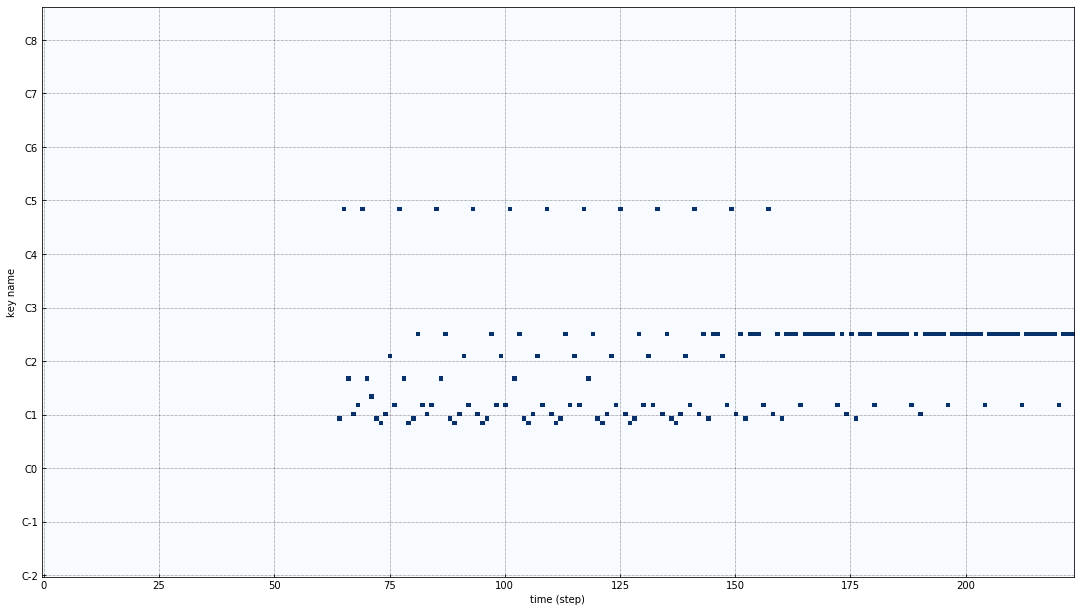

In [0]:
file = np.random.choice(files)
#file = files[]

print(file)
stub = stub_from_file(file, seq_len)
sample = generate_mid(stub, model, 10)
sample.write("../../../out/out_{}.mid".format(int(datetime.timestamp(datetime. now()))))

#sample.write('out.mid')
fig, axs = ppplt(sample.tracks[0])

fig.set_size_inches(18.5, 10.5)
plt.show()